# SSS restoring maps and timeseries

See
- https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/44
- https://github.com/ACCESS-NRI/dev_coupling/issues/63#issuecomment-3383664728
- https://github.com/AndyHoggANU/ACCESS-CM2-025-diagnostics/blob/5786ccf/MarginalSeas.ipynb

In [1]:
#parameters

### USER EDIT start
#esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=200
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1/notebooks/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebooks_dir = os.path.join(f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.makedirs(notebooks_dir, exist_ok=True)
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
try:
    from mkfigs_configdoc import mkmd,get_notebook_name
    notebook_name=get_notebook_name(notebook_name)
except ModuleNotFoundError:
    notebook_name='not_using_mkfigs.sh'
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 1 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 2 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'2.png',plotfolder+'mkmd/')
# needed for mkmd STOP

# a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Changed working directory to: /g/data/x77/aek156/access-om3-paper-1/notebooks
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/x77/aek156/access-om3-paper-1/notebooks/


In [2]:
import intake
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cmocean as cm
import cartopy.crs as ccrs
from shapely import geometry
import cftime
import textwrap

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


In [4]:
client

<Client: 'tcp://127.0.0.1:38465' processes=14 threads=14, memory=63.00 GiB>

In [5]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [6]:
om3exptname = os.path.basename(os.path.dirname(esm_file))
om3exptname

'MC_25km_jra_iaf-1.0-beta-5165c0f8'

## Load ACCESS-OM3 data from ESM datastore

In [7]:
datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

frequency = '1mon'

In [8]:
salt_flux_added_om3 = datastore.search(variable="salt_flux_added",
                                       frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['salt_flux_added']

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [9]:
# surface_salt_om3 = datastore.search(variable="sos", frequency=frequency).to_dask(
surface_salt_om3 = datastore.search(variable="sos").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1}, 
        decode_timedelta=True, use_cftime=True))['sos']
surface_salt_om3 = surface_salt_om3.resample(time='ME').mean('time')  # resample monthly to match salt_flux_added_om3 and OM2 data

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
if IAF:
    salt_flux_added_om3 = salt_flux_added_om3.convert_calendar("proleptic_gregorian", use_cftime=True)
    surface_salt_om3 = surface_salt_om3.convert_calendar("proleptic_gregorian", use_cftime=True)

In [11]:
cell_area_om3 = datastore.search(variable='areacello', path=".*output000.*").to_dask()
salt_flux_scaled_om3 = salt_flux_added_om3 * cell_area_om3['areacello']

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [12]:
# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
if om3exptname == "25km-iaf-test-for-AK-expt-7df5ef4c":
    salt_flux_added_om3 = salt_flux_added_om3.isel(yh=slice(10, None))
    surface_salt_om3 = surface_salt_om3.isel(yh=slice(10, None))
    salt_flux_scaled_om3 = salt_flux_scaled_om3.isel(yh=slice(10, None))

In [13]:
salt_flux_added_om3.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [14]:
salt_flux_added_om3.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [15]:
# set time range

if IAF:
    # datestop = cftime.DatetimeProlepticGregorian(2018, 12, 31, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
    datestop = salt_flux_added_om3.time.values[-1] # final date in data
    datelist = list(cftime.to_tuple(datestop))
    datelist[0] -= 10  # last 10 years
    datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
    timerange = slice(datestart, datestop)
else:
    timerange = slice(cftime.DatetimeNoLeap(1932, 1, 1, 0, 0, 0, 0),
                      cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))

# timerange = slice(None, None)

In [16]:
datestart

cftime.datetime(2004, 12, 16, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [17]:
datestop

cftime.DatetimeProlepticGregorian(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7 - but **note that this does not include topography fixes in the latest OM2 and CM2 configs** - see https://github.com/ACCESS-Community-Hub/access-om3-paper-1/issues/44#issuecomment-3379637468

In [18]:
if IAF:
    om2exptname = '025deg_jra55_iaf_omip2_cycle1'
    frequency = '1mon'
else:
    om2exptname = '025deg_jra55_ryf9091_gadi'
    frequency='1yr' # for 025deg_jra55_ryf9091_gadi

datastore = intake.cat.access_nri[om2exptname]

In [19]:
catalog = intake.cat.access_nri

In [20]:
var = catalog[om2exptname].search(variable='sfc_salt_flux_restore',
                                  frequency=frequency)

In [21]:
salt_flux_added_om2 = var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['sfc_salt_flux_restore']

In [22]:
if IAF:
    salt_flux_added_om2 = salt_flux_added_om2.convert_calendar("proleptic_gregorian", use_cftime=True)

In [23]:
cell_area_om2 = catalog[om2exptname].search(variable='area_t', path=".*output000.*").to_dask()

In [24]:
salt_flux_scaled_om2 = salt_flux_added_om2 * cell_area_om2['area_t']

In [25]:
try:
    var = catalog[om2exptname].search(variable='surface_salt',frequency=frequency)
    surface_salt_om2 = var.to_dask(
                xarray_open_kwargs=dict(
                chunks={"time": -1},
                decode_timedelta=True,
                use_cftime=True)
    )['surface_salt']
except ValueError:  # use top level of 3d salt instead
    var = catalog[om2exptname].search(variable='salt',frequency=frequency)
    surface_salt_om2 = var.to_dask(
                xarray_open_kwargs=dict(
                chunks={"time": -1},
                decode_timedelta=True,
                use_cftime=True)
    )['salt'].isel(st_ocean=0)

## Make plots

### Define regions
- match https://github.com/AndyHoggANU/ACCESS-CM2-025-diagnostics/blob/5786ccf/MarginalSeas.ipynb
- see https://github.com/ACCESS-NRI/dev_coupling/issues/63#issuecomment-3383664728

Text(0.5, 1.0, 'Regions (BUG: incorrect shapes north of 65°N)')

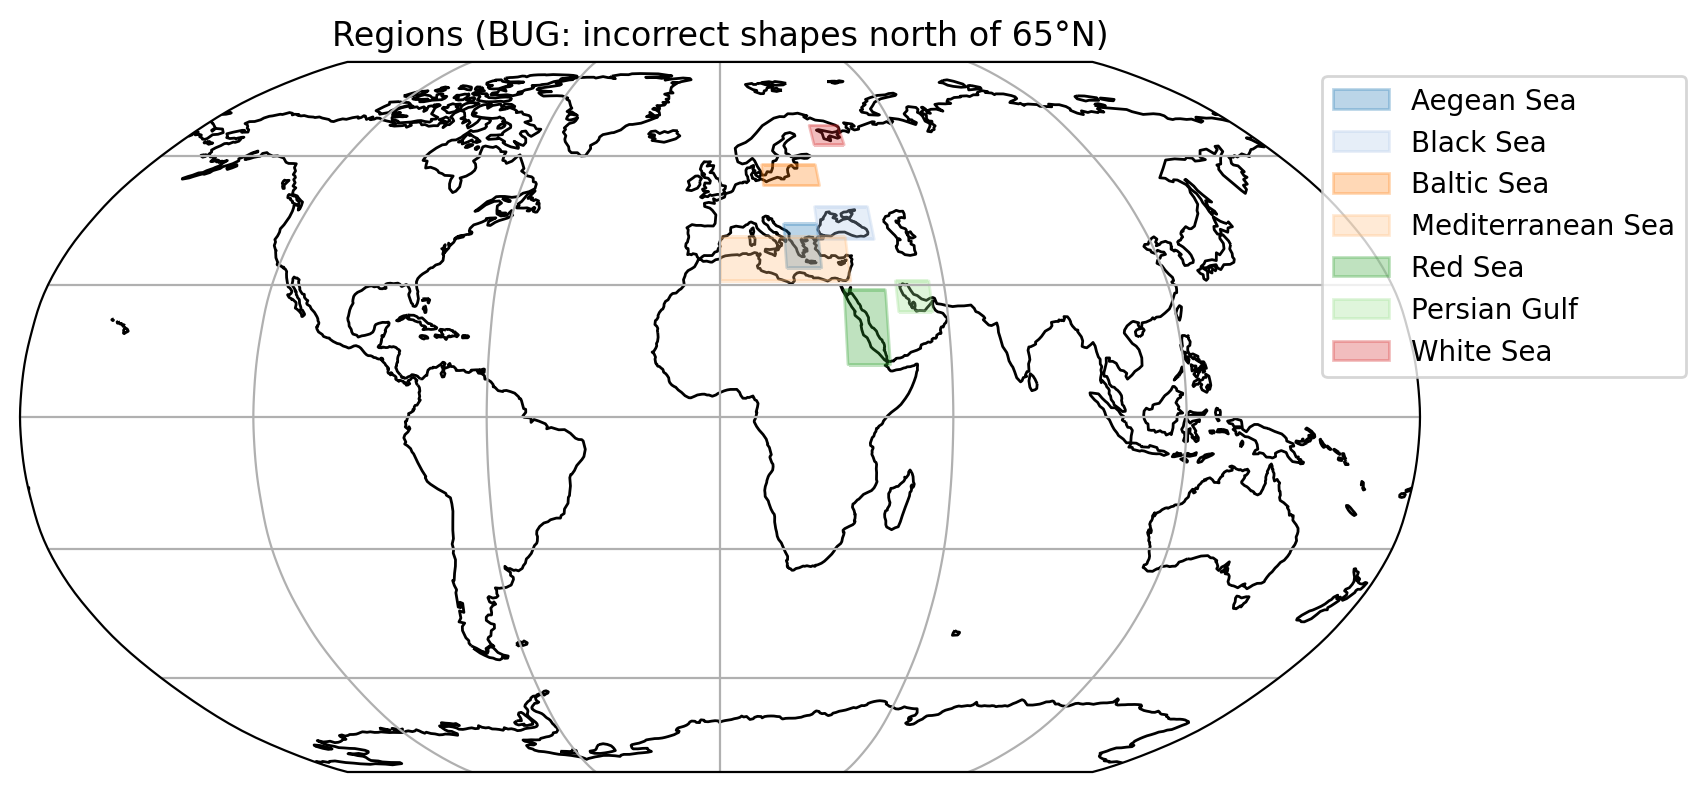

In [26]:
regions = { # [minx, maxx, miny, maxy], using model longitude range (-280 to 80)
    # "Global": [-280, 80, -90, 90],
    # "Arctic": [-280, 80, 65, 90],
    # "Southern Ocean": [-280, 80, -82, -63],
    # "ACC": [-280, 80, -63, -45],
    # "Southern Pacific": [-210, -70, -45, -20],
    # "Tropical Pacific": [-240, -100, -20, 20],
    # "North Pacific": [-240, -100, 20, 65],
    # "South Atlantic": [-60, 20, -45, -20],
    # "Tropical Atlantic": [-70, 20, -20, 20],
    # "North Atlantic": [-100, 0, 20, 65],
    # "Indian": [30, 120, -45, 20],
    "Aegean Sea": [18, 27.5, 34, 44],
    "Black Sea": [27.5, 43, 40.5, 48],
    "Baltic Sea": [13, 30, 53, 58],
    "Mediterranean Sea": [0, 35, 31, 41],
    "Red Sea": [33, 44, 12, 29],
    "Persian Gulf": [47, 56, 24, 31],
    "White Sea": [31, 41, 63, 68],
}
regions = {k: dict(zip(["minx", "maxx", "miny", "maxy"], v)) for k, v in regions.items()}  # convert to dicts

for r, d in regions.items():
    for k, x in d.items():
        if k in ["minx", "maxx"] and x != max(-280, min(x, 80)):
            raise ValueError(f"{r} {k} = {x} is outside the range -280 to 80")

fig = plt.figure(figsize=(10, 4))

colors = mpl.color_sequences['tab20']
try:  # set Global color to white 
    colors[list(regions.keys()).index("Global")] = (1, 1, 1)
except ValueError:
    pass

ax = plt.axes(position=[0.05,0.05,0.7,0.9], projection=ccrs.Robinson())
ax.coastlines(resolution="110m")
ax.gridlines(draw_labels=False)

legend_elements = []
for i, (region, limits) in enumerate(regions.items()):
    ax.add_geometries([geometry.box(**limits)], crs=ccrs.PlateCarree(), color=colors[i], alpha=0.3)
    legend_elements.append(Patch(color=colors[i], alpha=0.3, label=region))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1.00))
plt.title("Regions (BUG: incorrect shapes north of 65°N)")

### Timeseries

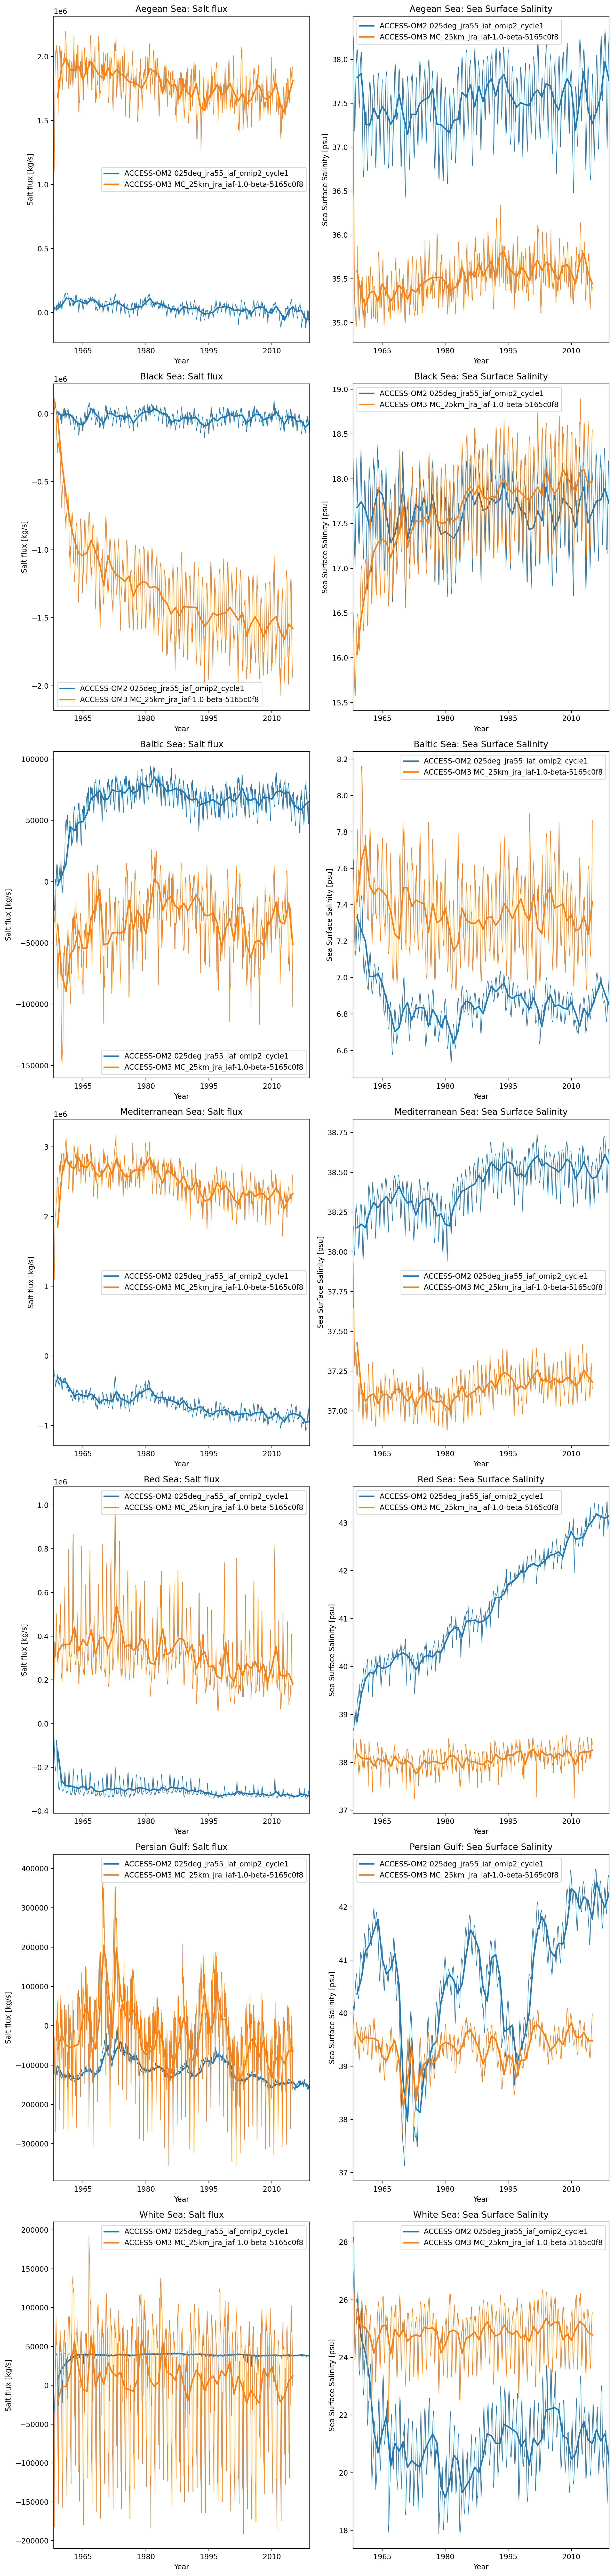

CPU times: user 35.4 s, sys: 6.91 s, total: 42.3 s
Wall time: 1min 2s


In [27]:
%%time
fig, axes = plt.subplots(
    nrows=len(regions), ncols=2, figsize=(12, 50))

for i, (region, bounds) in enumerate(regions.items()):
    salt_restore_OM3 = (
        salt_flux_scaled_om3
        .sel(xh=slice(bounds["minx"], bounds["maxx"])).sum('xh', keep_attrs=True)
        .sel(yh=slice(bounds["miny"], bounds["maxy"])).sum('yh', keep_attrs=True)
        .load()
    )
    salt_restore_OM2 = (
        salt_flux_scaled_om2
        .sel(xt_ocean=slice(bounds["minx"], bounds["maxx"])).sum('xt_ocean', keep_attrs=True)
        .sel(yt_ocean=slice(bounds["miny"], bounds["maxy"])).sum('yt_ocean', keep_attrs=True)
        .load()
    )

    salinity_OM3 = (
        surface_salt_om3
        .sel(xh=slice(bounds["minx"], bounds["maxx"])).mean('xh', keep_attrs=True)
        .sel(yh=slice(bounds["miny"], bounds["maxy"])).mean('yh', keep_attrs=True)
        .load()
    )
    salinity_OM2 = (
        surface_salt_om2
        .sel(xt_ocean=slice(bounds["minx"], bounds["maxx"])).mean('xt_ocean', keep_attrs=True)
        .sel(yt_ocean=slice(bounds["miny"], bounds["maxy"])).mean('yt_ocean', keep_attrs=True)
        .load()
    )

    ax1 = axes[i, 0]
    p = salt_restore_OM2.plot(ax=ax1, linewidth=.7)
    salt_restore_OM2.resample(time='1YE').mean('time').plot(
                ax=ax1,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM2 {om2exptname}"
            )
    p = salt_restore_OM3.plot(ax=ax1, linewidth=.7)
    salt_restore_OM3.resample(time='1YE').mean('time').plot(
                ax=ax1,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM3 {om3exptname}"
            )
    ax1.set_ylabel("Salt flux [kg/s]")
    ax1.set_title(f"{region}: Salt flux")
    ax1.set_xlabel("Year")
    ax1.autoscale(enable=True, axis='x', tight=True)
    ax1.legend()

    ax2 = axes[i, 1]
    p = salinity_OM2.plot(ax=ax2, linewidth=.7)
    salinity_OM2.resample(time='1YE').mean('time').plot(
                ax=ax2,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM2 {om2exptname}"
            )
    p = salinity_OM3.plot(ax=ax2, linewidth=.7)
    salinity_OM3.resample(time='1YE').mean('time').plot(
                ax=ax2,
                linewidth=2,
                color=p[-1].get_color(),
                label=f"ACCESS-OM3 {om3exptname}"
            )
    ax2.set_ylabel(f"{salinity_OM3.attrs['long_name']} [{salinity_OM3.attrs['units']}]")
    ax2.set_title(f"{region}: {salinity_OM3.attrs['long_name']}")
    ax2.set_xlabel("Year")
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.legend()

plt.tight_layout()
# plt.savefig(f"{plotfolder}/Salinity_restoring_025_deg_all_regions.png", dpi=300)

if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
if notebook_name!='not_using_mkfigs.sh': mkmd("Salinity Restoring","`"+notebook_name+"`: Timeseries of salinity restoring.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')

plt.show()

### Maps

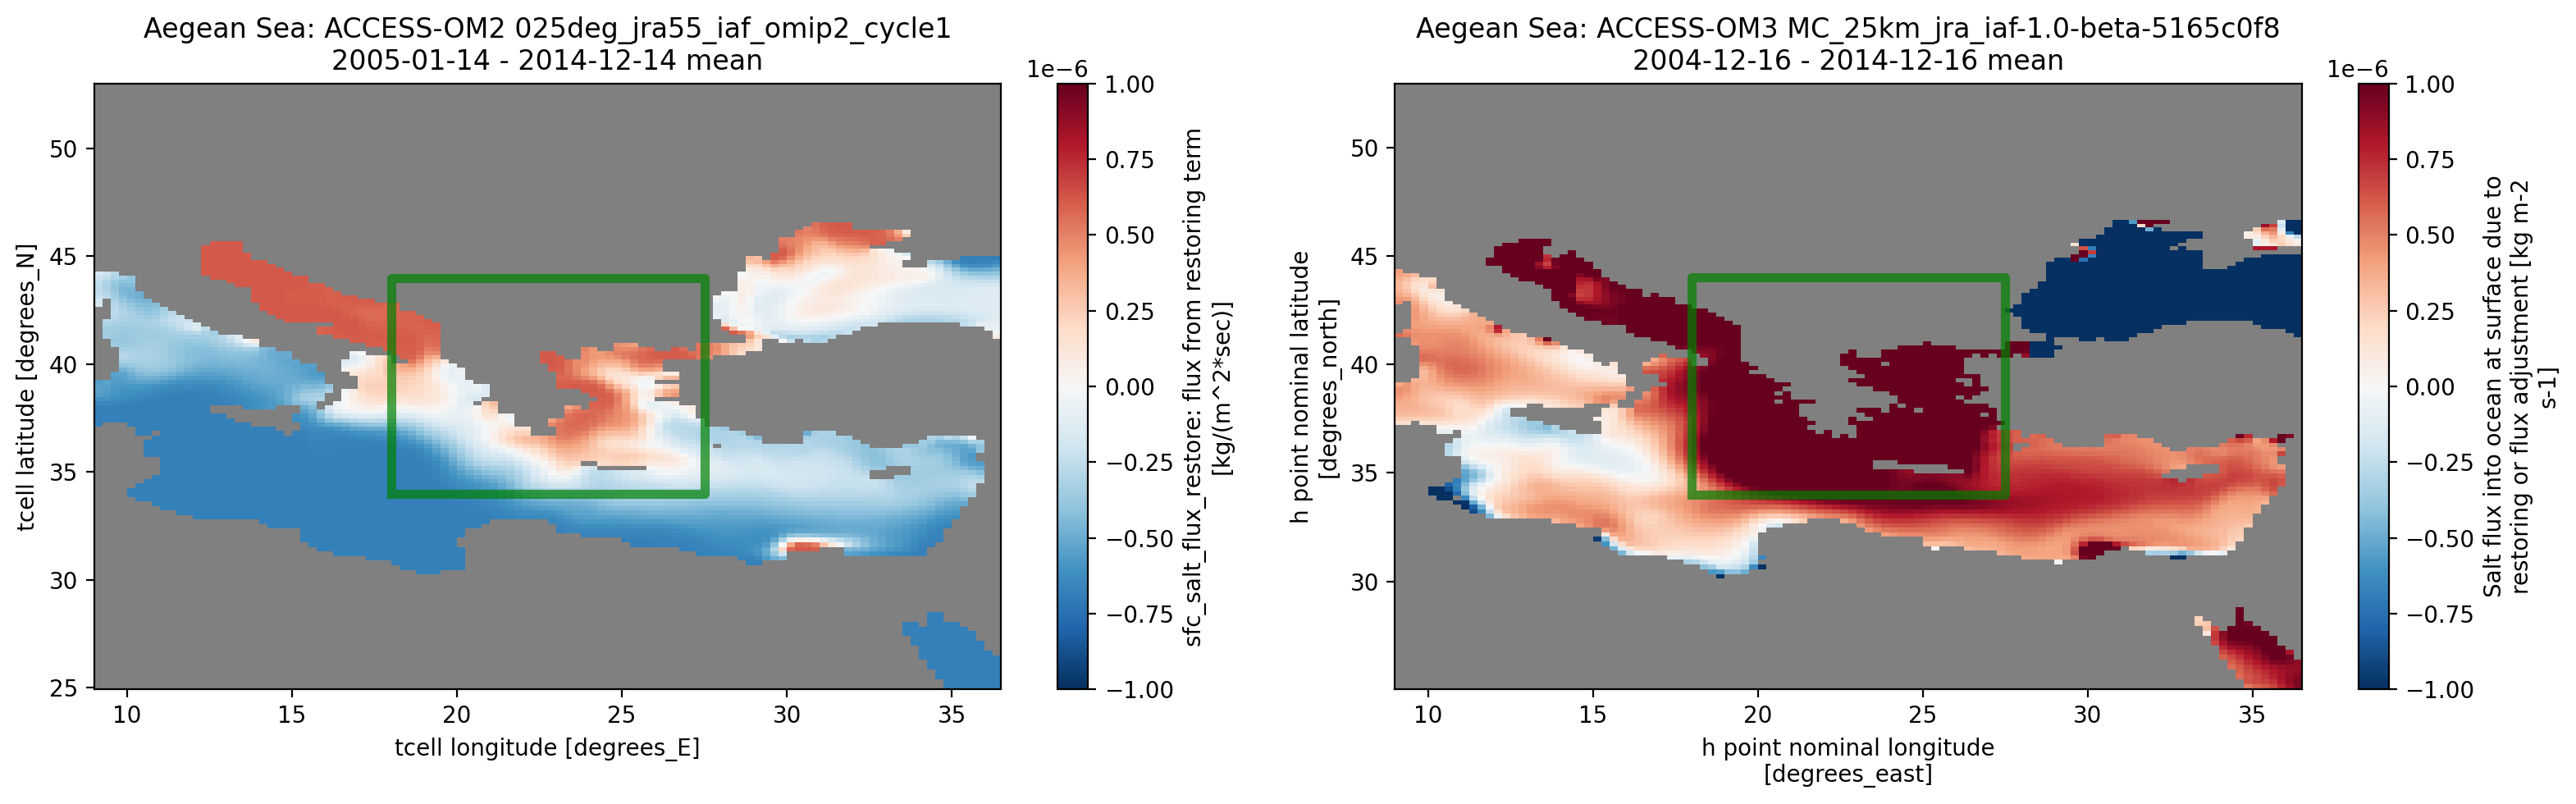

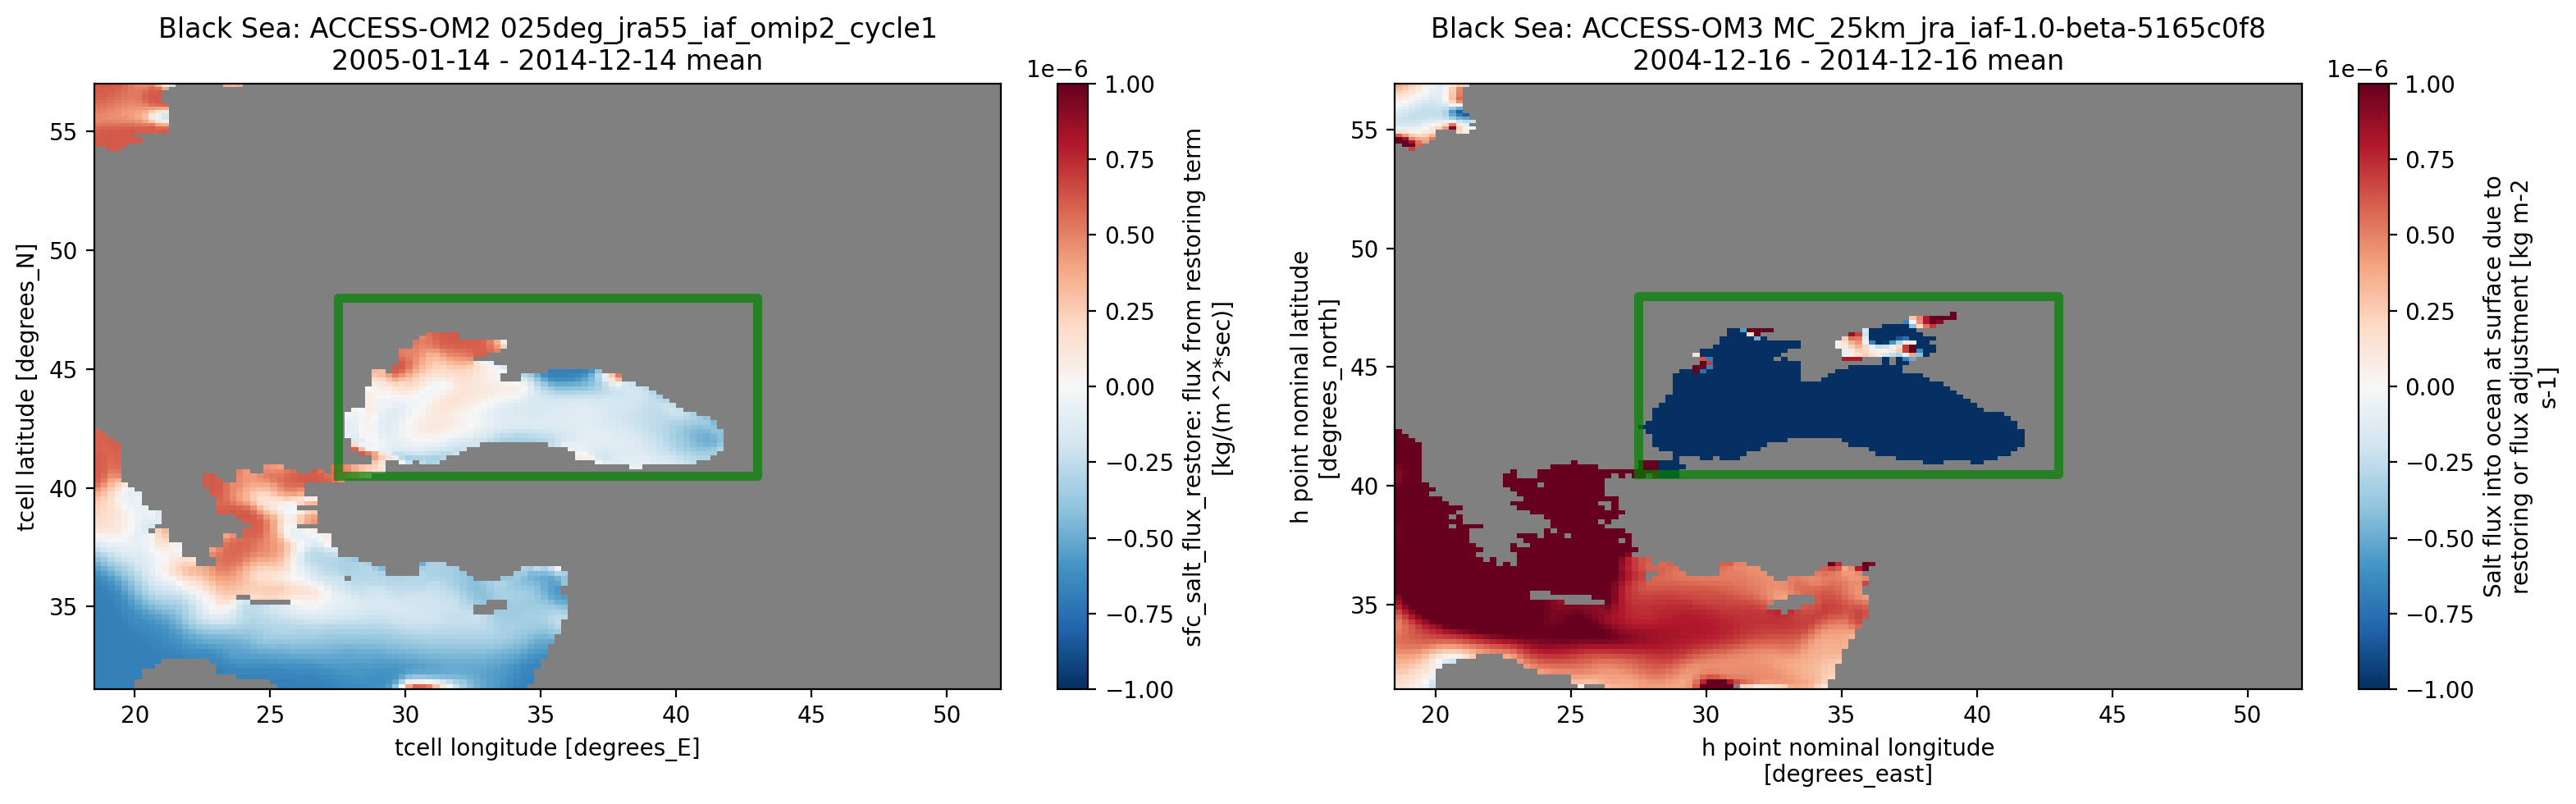

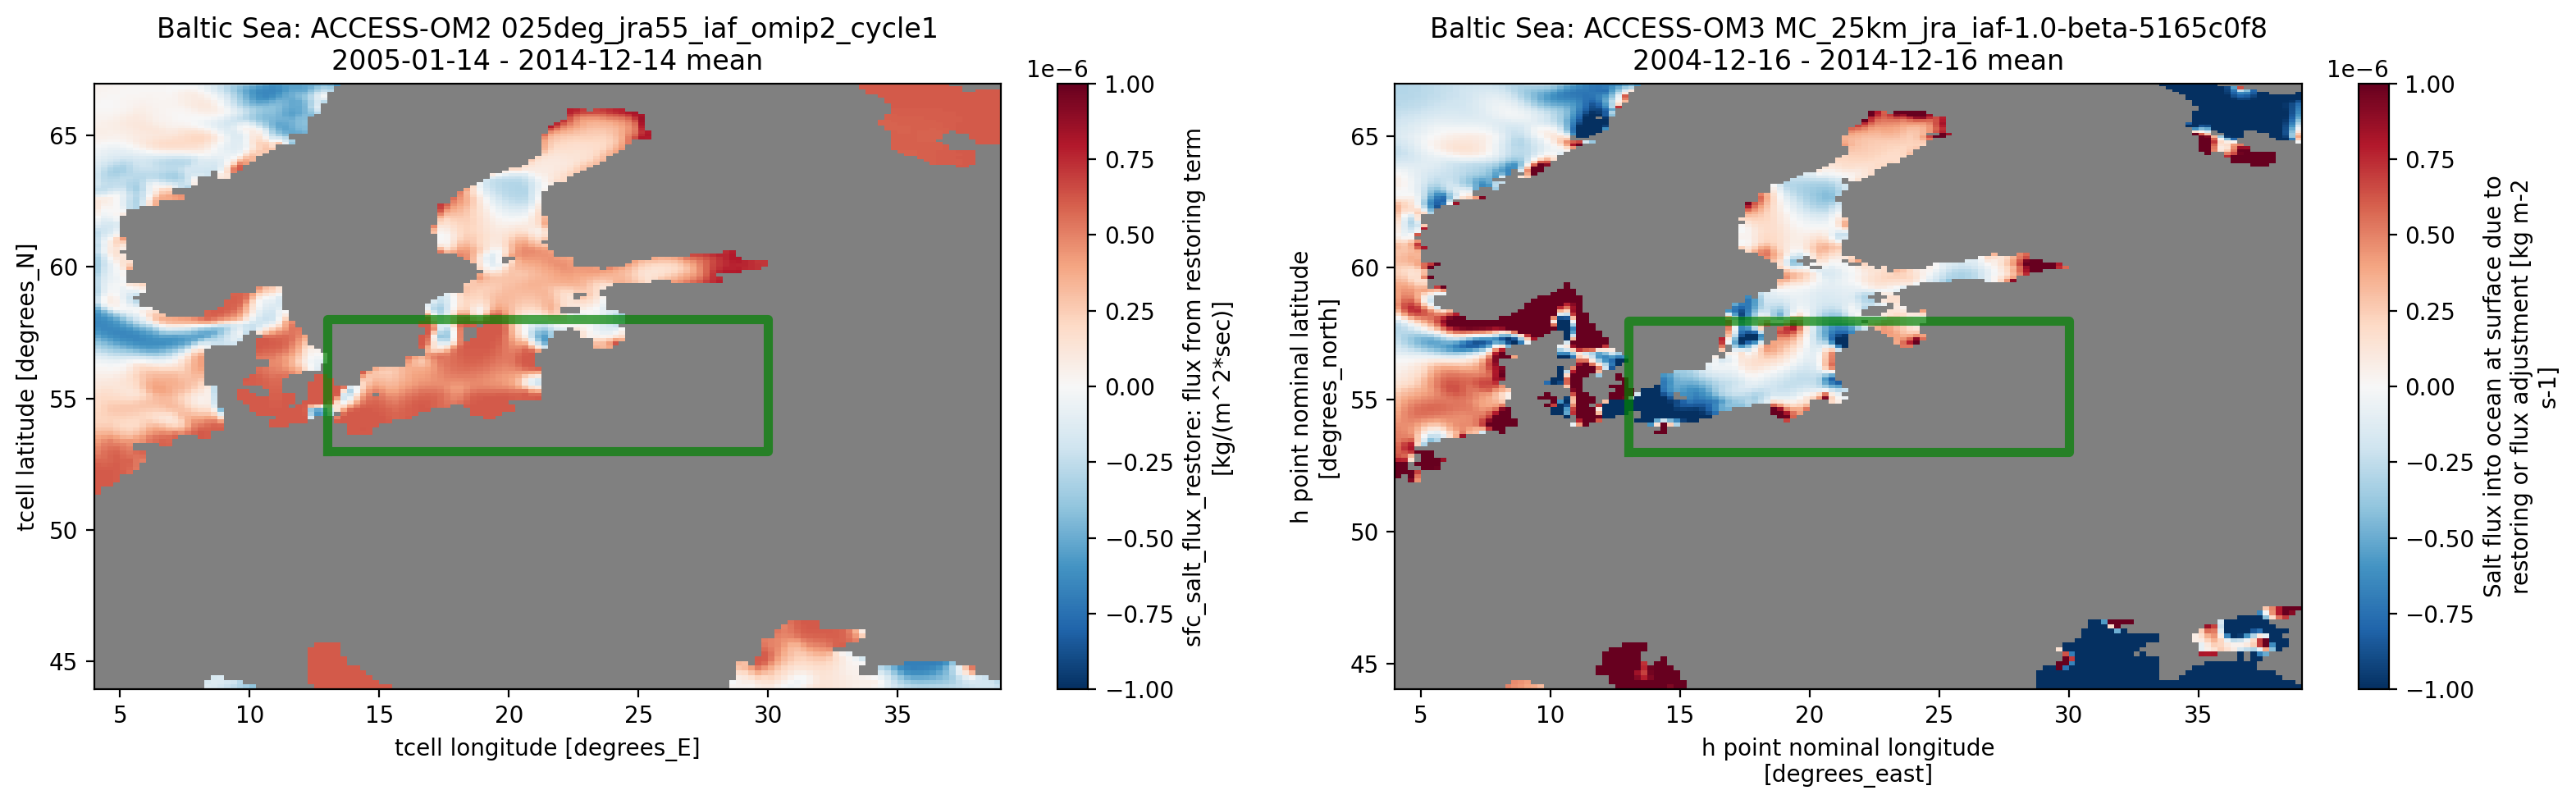

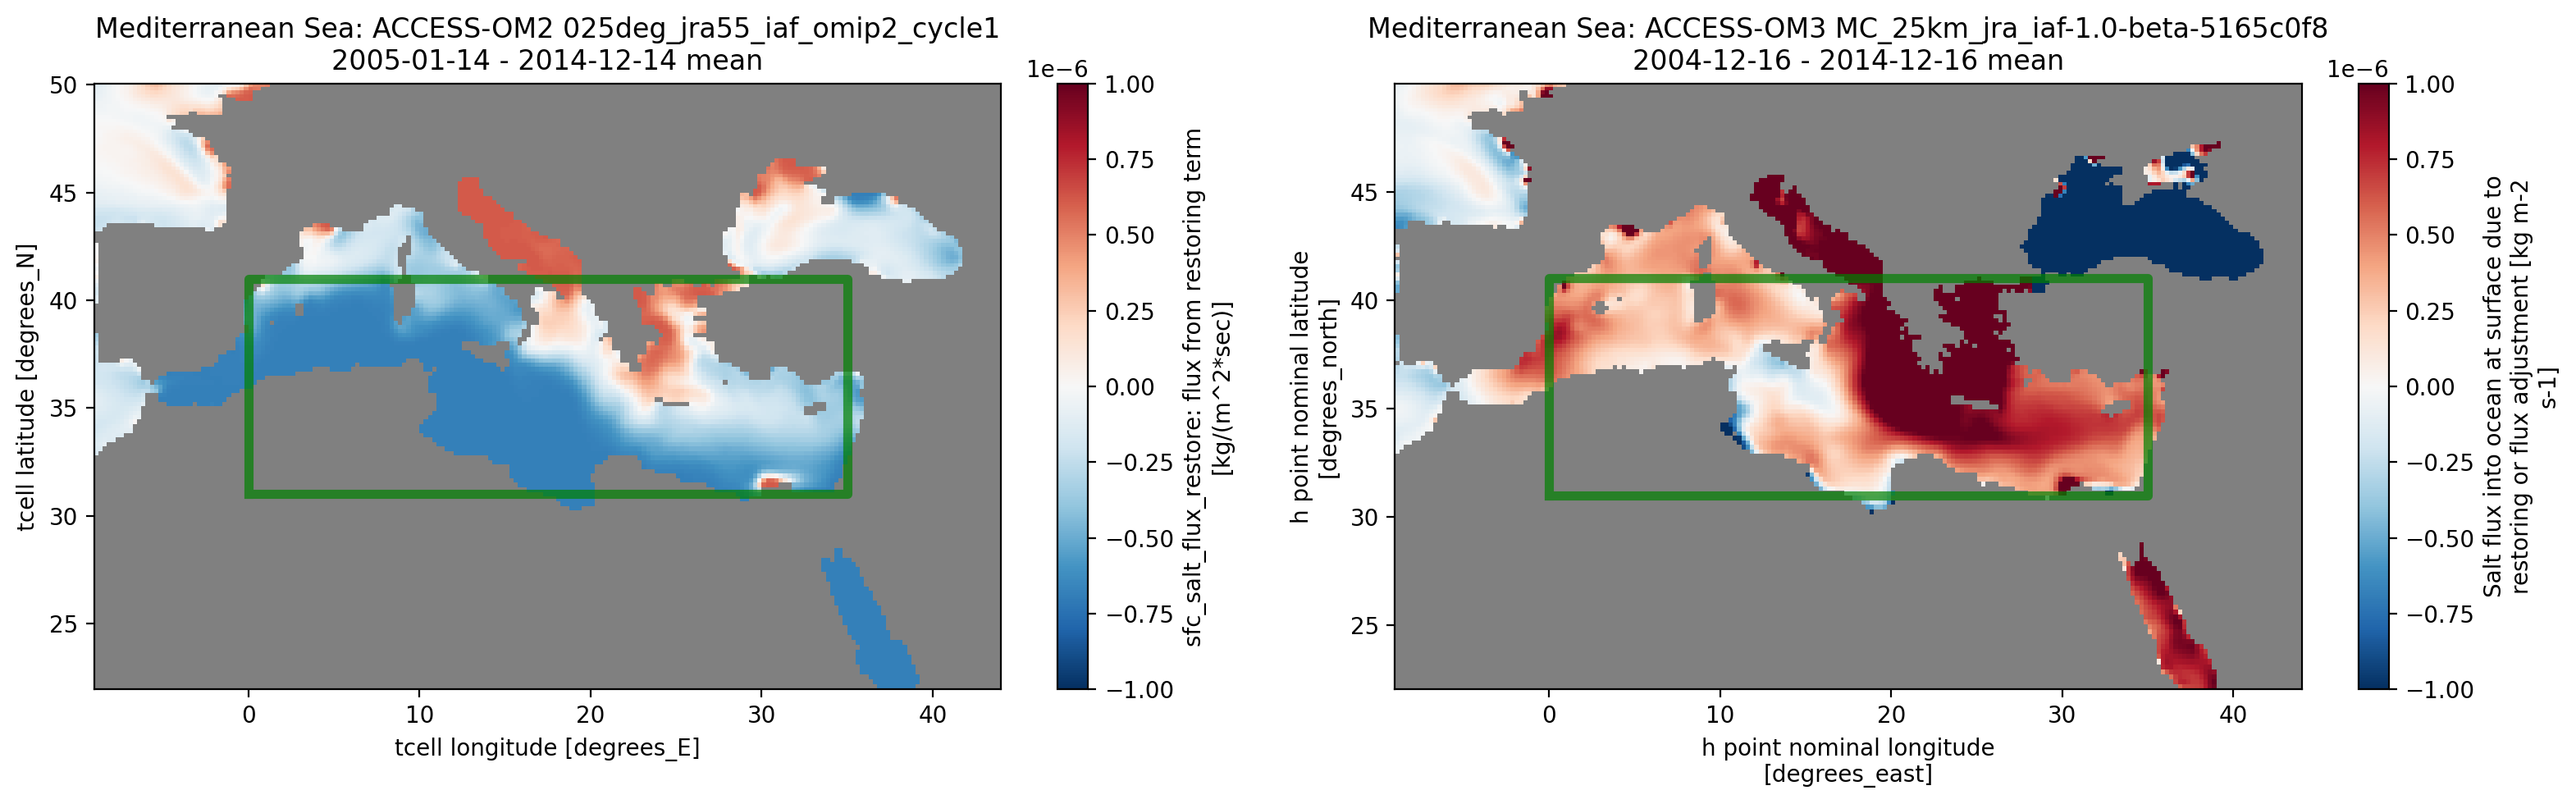

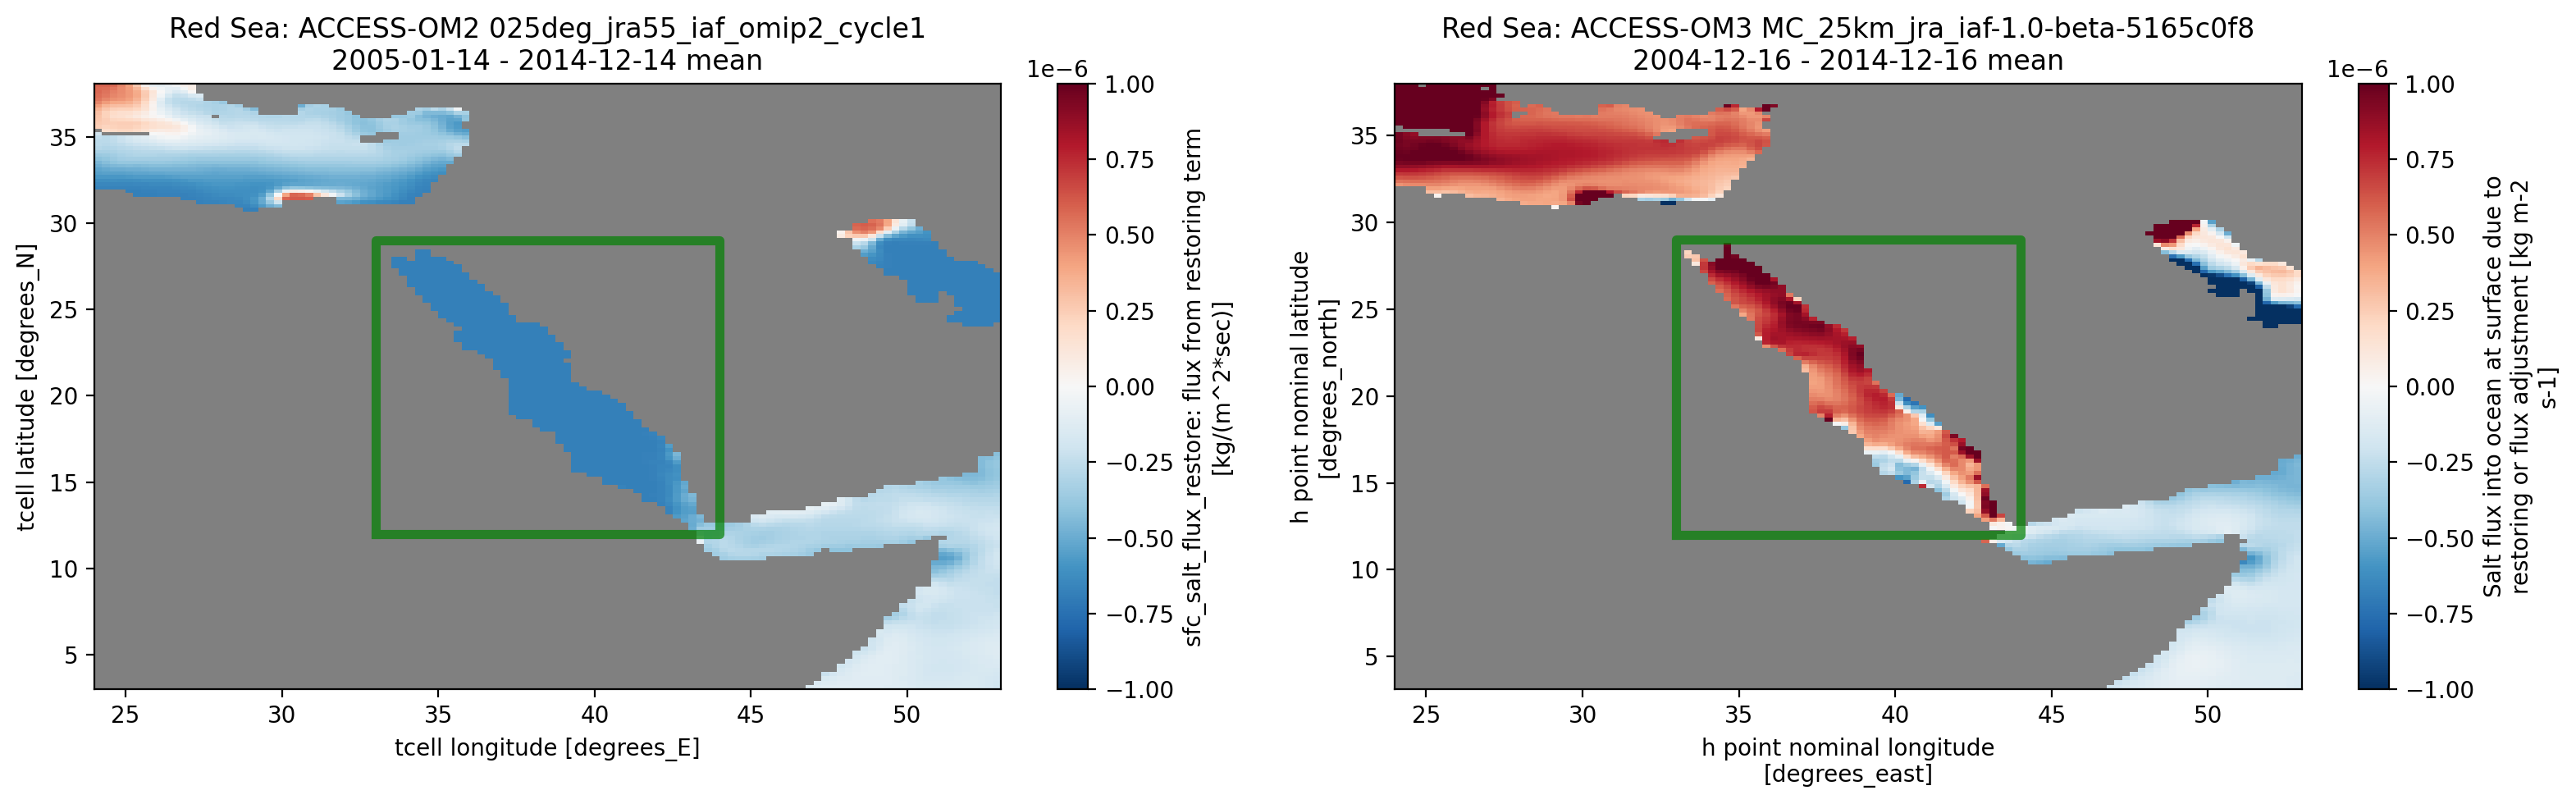

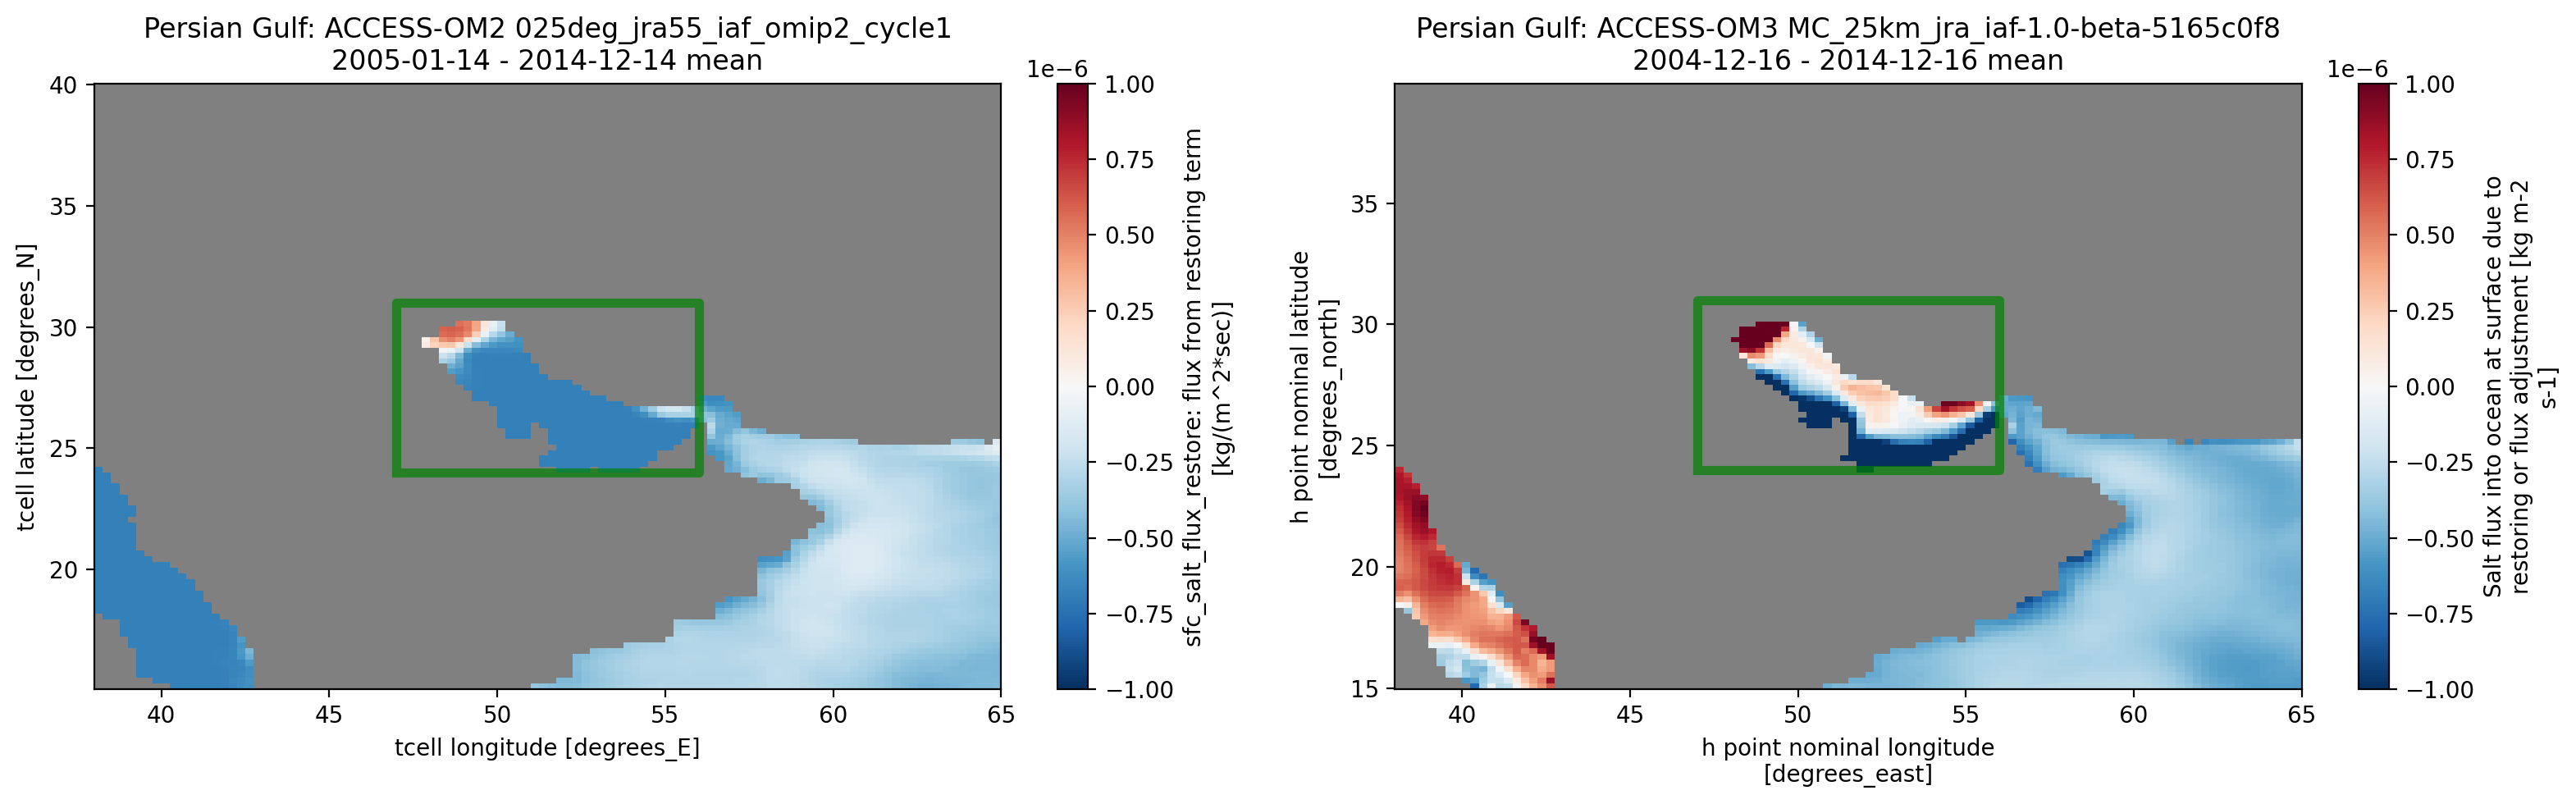

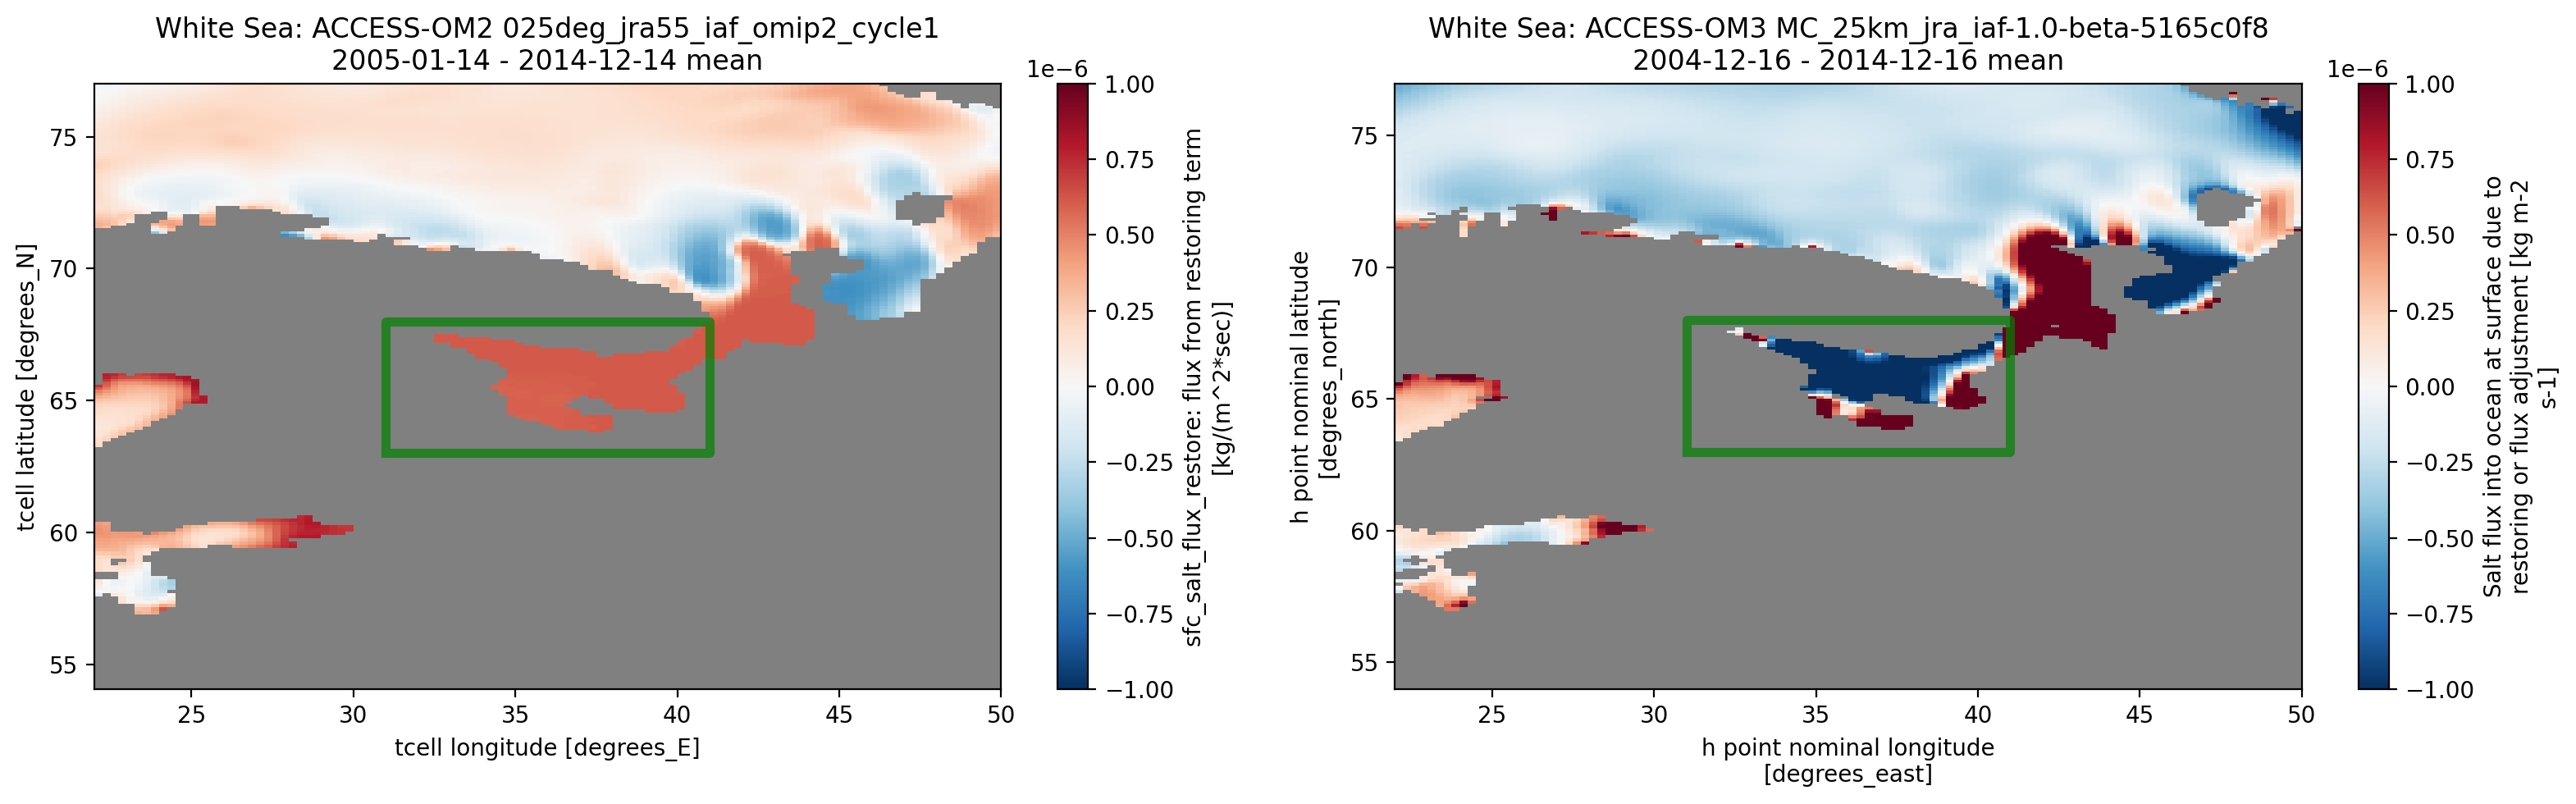

CPU times: user 9.43 s, sys: 1.33 s, total: 10.8 s
Wall time: 11 s


In [28]:
%%time
margin = 9
vmax = 1e-6
for region, bounds in regions.items():
    minx = bounds["minx"]
    maxx = bounds["maxx"]
    miny = bounds["miny"]
    maxy = bounds["maxy"]
    xslice = slice(minx-margin, maxx+margin)
    yslice = slice(miny-margin, maxy+margin)
    plt.figure(figsize=(16,5))

    # Right subplot (ACCESS-OM3)
    plt.subplot(122).set_facecolor('gray')  # gray land points
    data = salt_flux_added_om3.sel(xh=xslice).sel(yh=yslice).sel(time=timerange)
    p1 = data.mean('time').plot(vmax=vmax, add_colorbar=False)
    plt.plot([minx, maxx, maxx, minx, minx],
             [miny, miny, maxy, maxy, miny],
             color='green', linewidth=4, alpha=0.7)
    plt.title(f'{region}: ACCESS-OM3 {om3exptname}\n{data.time.values[0].strftime("%Y-%m-%d")} - {data.time.values[-1].strftime("%Y-%m-%d")} mean')
    cbar1 = plt.colorbar(p1, orientation="vertical")
    cbar1.set_label('\n'.join(textwrap.wrap(
        f"{salt_flux_added_om3.attrs['long_name']} [{salt_flux_added_om3.attrs['units']}]",
        width=40)))

    # Left subplot (ACCESS-OM2)
    plt.subplot(121).set_facecolor('gray')  # gray land points
    data = salt_flux_added_om2.sel(xt_ocean=xslice).sel(yt_ocean=yslice).sel(time=timerange)
    p2 = data.mean('time').plot(vmax=vmax, add_colorbar=False)
    plt.plot([minx, maxx, maxx, minx, minx],
             [miny, miny, maxy, maxy, miny],
             color='green', linewidth=4, alpha=0.7)
    plt.title(f'{region}: ACCESS-OM2 {om2exptname}\n{data.time.values[0].strftime("%Y-%m-%d")} - {data.time.values[-1].strftime("%Y-%m-%d")} mean')
    cbar2 = plt.colorbar(p2, orientation="vertical")
    cbar2.set_label('\n'.join(textwrap.wrap(
        f"{salt_flux_added_om2.attrs['long_name']} [{salt_flux_added_om2.attrs['units']}]",
        width=55)))
    
    plt.tight_layout()
    plt.show()